In [1]:
import pandas as pd
import numpy as np

In [2]:
# importation des données d'assurance vie

df = pd.read_excel("HistoFluxAssurVie V3bis.xlsx")

In [3]:
# on supprime les colonnes inutiles
df = df.drop([" AVT ", " RVT ", " TP- ", " TRF ", " TT- "], axis= 1)

In [4]:
# on donne des noms compréhensibles à nos variables

df.columns = ["TypeContrat", "AnneeSousc", "AnneeFlux", "Avances", "FluxDeces",
              "RemboursementAvance", "FluxRenonciation", "RachatPariel", "RachatTotal",
              "FluxSouscription", "FluxReversement"]

In [5]:
df.dtypes

TypeContrat             object
AnneeSousc               int64
AnneeFlux                int64
Avances                float64
FluxDeces              float64
RemboursementAvance    float64
FluxRenonciation       float64
RachatPariel           float64
RachatTotal            float64
FluxSouscription       float64
FluxReversement        float64
dtype: object

In [6]:
# On calcule l'ancienneté des contrats

df["AncienneteContrat"] = df["AnneeFlux"] - df["AnneeSousc"]

In [7]:
# on ajoute des colonnes indicatrices de rachat Total : 1 si rachat total, 0 sinon
for x in range(0,len(df.RachatPariel)):
    if df.loc[x, "RachatTotal"] == 0:
        df.loc[x, "IndicatriceRachatT"] = 0
    elif df.loc[x, "RachatTotal"] != 0:
        df.loc[x, "IndicatriceRachatT"] = 1

In [8]:
# on ajoute des colonnes indicatrices de rachat partiel : 1 si rachat partiel, 0 sinon
for x in range(0,len(df.RachatPariel)):
    if df.loc[x, "RachatPariel"] == 0.0:
        df.loc[x, "IndicatriceRachatP"] = 0
    elif df.loc[x, "RachatPariel"] != 0.0:
        df.loc[x, "IndicatriceRachatP"] = 1

In [9]:
# on ajoute des colonnes indicatrices de décès : 1 si décès, 0 sinon
for x in range(0,len(df.FluxDeces)):
    if df.loc[x, "FluxDeces"] == 0.0:
        df.loc[x, "Deces"] = 0
    elif df.loc[x, "FluxDeces"] != 0.0:
        df.loc[x, "Deces"] = 1

In [10]:
df["IndicatriceRachatP"] = df["IndicatriceRachatP"].apply(lambda x: int(x))

In [11]:
df["IndicatriceRachatT"] = df["IndicatriceRachatT"].apply(lambda x: int(x))

# Dataviz

In [12]:
import matplotlib as plt

In [13]:
%matplotlib inline

In [14]:
df.groupby("TypeContrat")["FluxDeces"].sum()

TypeContrat
CAPI     0.000000e+00
Nonlu   -5.019558e+07
REPU    -4.754547e+08
REVL    -8.027249e+08
SUC     -1.110707e+08
Name: FluxDeces, dtype: float64

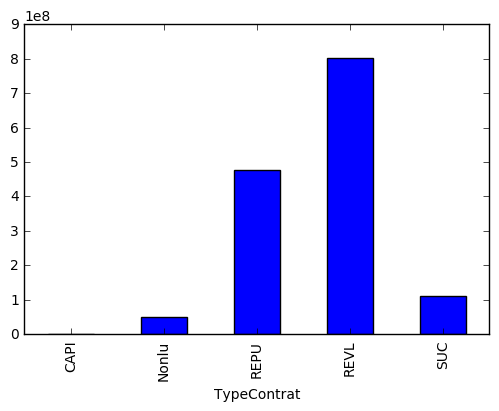

In [40]:
# visualison les prestations deces en focntion du type de contrat
(df.groupby("TypeContrat")["FluxDeces"].sum()*(-1)).plot(kind="bar")

In [17]:
stats = df.groupby("TypeContrat")["IndicatriceRachatT"].sum()
stats

TypeContrat
CAPI     59
Nonlu    38
REPU     65
REVL     52
SUC      13
Name: IndicatriceRachatT, dtype: int64

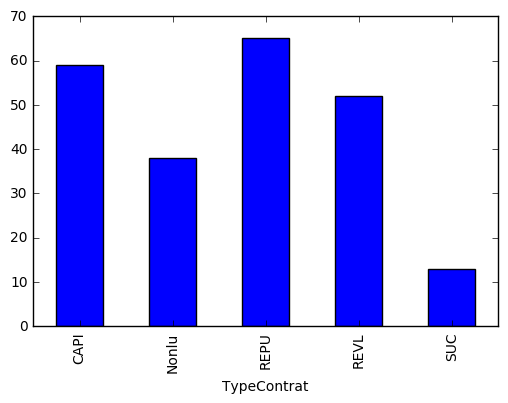

In [18]:
stats.plot(kind = "bar")

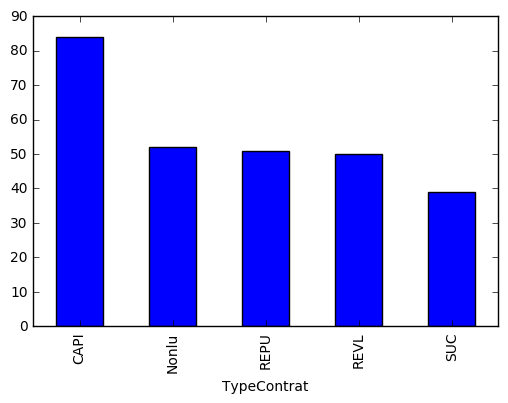

In [20]:
df.groupby("TypeContrat")["IndicatriceRachatP"].sum().plot(kind= "bar")

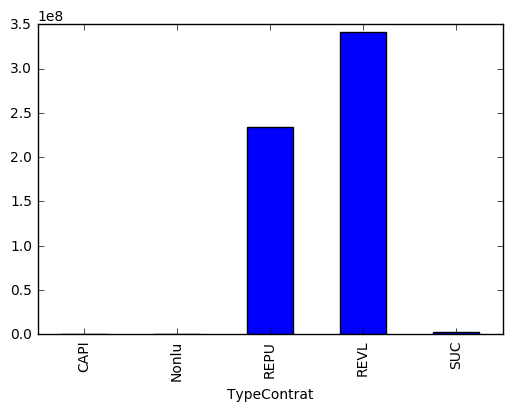

In [39]:
(df.groupby("TypeContrat")["Avances"].sum()*(-1)).plot(kind = "bar")

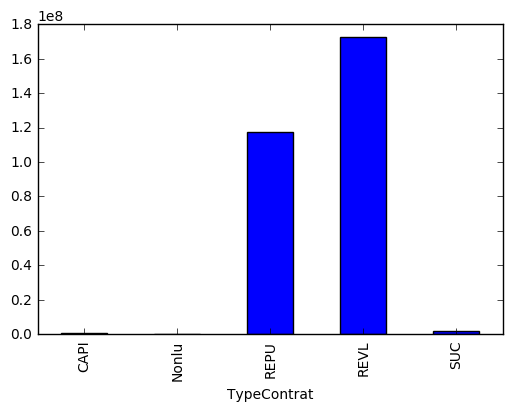

In [23]:
df.groupby("TypeContrat")["RemboursementAvance"].sum().plot(kind = "bar")

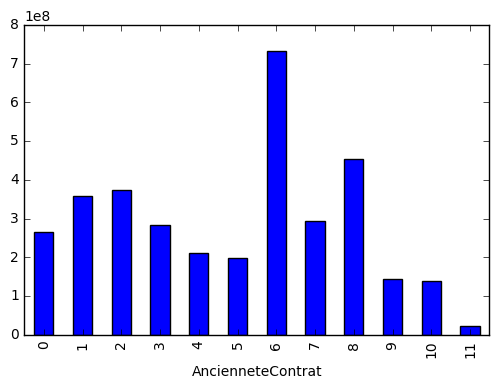

In [38]:
(df.groupby("AncienneteContrat")["RachatPariel"].sum()*(-1)).plot(kind = "bar")

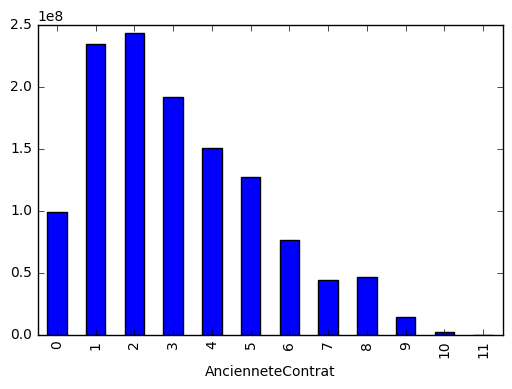

In [36]:
(df.groupby("AncienneteContrat")["RachatTotal"].sum()*(-1)).plot(kind = "bar")

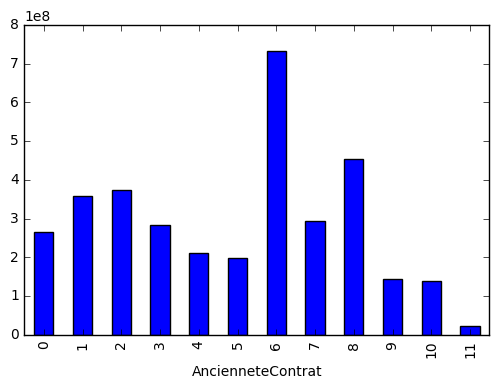

In [35]:
(df.groupby("AncienneteContrat")["RachatPariel"].sum()*(-1)).plot(kind = "bar")

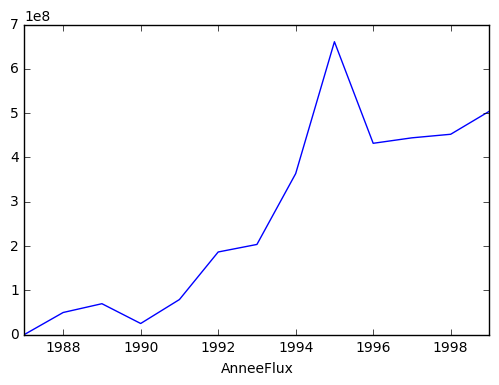

In [41]:
(df.groupby("AnneeFlux")["RachatPariel"].sum()*(-1)).plot()

# estimation des lois de rachat

Pour l'estimation des taux de rachat par Kaplan Meier, nous allons effectuer quelques hypothèses sur les interactions entre les rachats et les décès:
  - En ce qui concerne le rachat total:
        S'il ya décès sur le contrat et rachat total pour la même année, on considère
        que le rachat est consécutif au décès et donc on ne garde que l'évènement décès.
  - Pour ce qui est du rachat partiel:
        S'il ya décès et en même temps rachat partiel, on considère que l'évènement primordial est le rachat partiel.
        c'est à dire que le décès n'a pas donné lieu à une résiliation de contrat.

In [191]:
# Application sur le rachat total
for i in range(len(df)):
    if df.loc[i,"FluxDeces"]!=0.0 and df.loc[i, "RachatTotal"] != 0.0:
        df.loc[i,"DecesOuRachatT"] = 1
        df.loc[i, "rachatT"]      = 0
    elif df.loc[i, "FluxDeces"] != 0 and df.loc[i, "RachatTotal"] == 0:
        df.loc[i,"DecesOuRachatT"] = 1
        df.loc[i, "rachatT"]      = 0
    elif df.loc[i, "FluxDeces"] == 0 and df.loc[i, "RachatTotal"] != 0:
        df.loc[i, "DecesOuRachatT"] = 0
        df.loc[i, "rachatT"]       = 1
    elif df.loc[i, "FluxDeces"] ==0 and df.loc[i, "RachatTotal"] == 0:
        df.loc[i, "DecesOuRachatT"] = 0
        df.loc[i, "rachatT"]       = 0

In [192]:
# Application sur le rachat partiel
for i in range(len(df)):
    if df.loc[i,"FluxDeces"]!=0.0 and df.loc[i, "RachatPariel"] != 0.0:
        df.loc[i,"DecesOuRachatP"] = 0
        df.loc[i, "rachatP"]      = 1
    elif df.loc[i, "FluxDeces"] != 0 and df.loc[i, "RachatPariel"] == 0:
        df.loc[i,"DecesOuRachatP"] = 1
        df.loc[i, "rachatP"]      = 0
    elif df.loc[i, "FluxDeces"] == 0 and df.loc[i, "RachatPariel"] != 0:
        df.loc[i, "DecesOuRachatP"] = 0
        df.loc[i, "rachatP"]       = 1
    elif df.loc[i, "FluxDeces"] ==0 and df.loc[i, "RachatPariel"] == 0:
        df.loc[i, "DecesOuRachatP"] = 0
        df.loc[i, "rachatP"]       = 0

In [193]:
rachat_total = df.groupby("AnneeFlux")[["rachatT","DecesOuRachatT"]].sum()

In [201]:
def kaplan_meier(df):
    """
    Cette fonction calcul le taux de rachat
    en utilisant l'estimateur de kaplan meier.
    """
    
    import pandas as pd
    df = pd.DataFrame(df)
    
    tableau = pd.DataFrame(columns = ["annee", "effectif_sous_risque", "deces_censure", "rachat",
                                       "rachat/effectif_sous_risque", "1-rachat/effectif_sous_risque",
                                       "Produit(1-rachat/effectif_sous_risque)"])
    
    tableau.loc[0] = [0, 324, 0, 0, 0, 0, 1]
    tableau.loc[1] = [1, 324, 0, 0, 0, 0, 1]
    
    for i in range(1, 13):
        tableau.loc[i+1,'annee'] = int(i+1)
        
        tableau.loc[i+1,'effectif_sous_risque'] = tableau.loc[i, "effectif_sous_risque"] - df.iloc[i, 0] - df.iloc[i, 1]
        
        tableau.loc[i+1,'deces_censure'] = df.iloc[i, 1]
        
        tableau.loc[i+1,'rachat'] = df.iloc[i, 0]
        
        tableau.loc[i+1,'rachat/effectif_sous_risque'] = tableau.loc[i+1, "rachat"]/tableau.loc[i+1, "effectif_sous_risque"]
        
        tableau.loc[i+1,'1-rachat/effectif_sous_risque'] = 1 - tableau.loc[i+1, "rachat/effectif_sous_risque"]
        
        tableau.loc[i+1,"Produit(1-rachat/effectif_sous_risque)"] = tableau.loc[i, "Produit(1-rachat/effectif_sous_risque)"]*tableau.loc[i+1,"1-rachat/effectif_sous_risque"]
    
    taux_rachat = 1 - tableau.loc[13, "Produit(1-rachat/effectif_sous_risque)"]
    return taux_rachat

In [194]:
kaplan_meier(rachat_total)

0.47651729318211811

In [195]:
rachat_partiel=df.groupby("AnneeFlux")[["rachatP","DecesOuRachatP"]].sum()

In [202]:
kaplan_meier(rachat_partiel)

(    annee  effectif_sous_risque  deces_censure  rachat  \
 0     0.0                 324.0            0.0     0.0   
 1     1.0                 324.0            0.0     0.0   
 2     2.0                 320.0            0.0     4.0   
 3     3.0                 316.0            0.0     4.0   
 4     4.0                 308.0            0.0     8.0   
 5     5.0                 292.0            1.0    15.0   
 6     6.0                 271.0            0.0    21.0   
 7     7.0                 246.0            1.0    24.0   
 8     8.0                 217.0            3.0    26.0   
 9     9.0                 185.0            1.0    31.0   
 10   10.0                 150.0            1.0    34.0   
 11   11.0                 116.0            0.0    34.0   
 12   12.0                  75.0            3.0    38.0   
 13   13.0                  38.0            0.0    37.0   
 
     rachat/effectif_sous_risque  1-rachat/effectif_sous_risque  \
 0                      0.000000              